# Assignment 2

### Ferenc Huszár, Nic Lane and Neil Lawrence

### 23rd February 2021

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures.

There are 230 marks given in total for this second assessment ($\approx 70\%$ of the total of 330 marks for this course), broken into three groups:
* (A) 75 marks for the guided questions on Residual Networks
* (B) 75 marks for the guided questions on RNNs
* (C) 80 marks for a mini-project of your choice

You can choose whichever mini-project you want to attempt, we give you a range of options. If you would like to do more of these, that's fine, but will only mark one, whichever appears fist in your submitted notebook. These tasks are a bit more exploratoy, you don't have to go overboard on them. Equally, if you struggle to get them to work the way you wanted/expected, please document what you tried and what you learned.

# A: Residual Networks

In these questions we will work with residual networks (ResNets). In order to save time, we won't be training these models ourselves. Pytorch provides pre-*trained* weights for a range of commonly used models in the `torchvision` package, including ResNets of various depth. Most of the pretrained ResNets available are slightly improved versions of those proposed in 'Deep Residual Learning for Image Recognition' by [He et al (2015)](https://arxiv.org/pdf/1512.03385.pdf).

Note: you can request colab to run a GPU by going to Runtime -> Change runtime type. However, since we are only going to work with single images, it is unlikely this will buy you significant speedup.


## Setting up: Blas the border collie

To start, we will look at whether ResNets of different length can correctly classify my friend's dog Blas as a Border Collie.

In [1]:
# !wget https://caballerojose.com/images/blas.jpg -P blas_the_dog/test

### Loading an image

We will use the Python Imaging Library (PIL) to load the image. Colab then displays the image in-line if it is the output of the last line in the cell. Hello Blas!

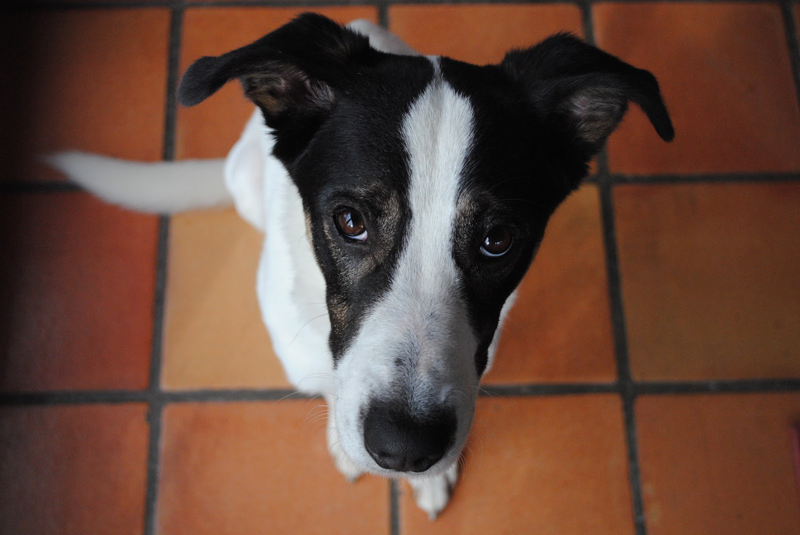

In [2]:
from PIL import Image
img = Image.open('blas_the_dog/test/blas.jpg')
img.resize((800,535))

### Transformations

ConvNets expect input images to be of a certain size, otherwise the dimensions of the tensors within the network don't work out. We have to resize this image so it is of size $224\times 224$ as the network expects. Secondly, when training neural networks, we often normalise the inputs (substract the mean and divide by the standard deviation). As this model was trained on ImageNet, we have to use the mean and standard deviation from this dataset. Thankfully, we don't have to compute this, as it's included in the [pytorch documentation](https://pytorch.org/vision/0.8/models.html) (as well as elsewhere on the internet).

We will use `transforms` from the `torchvision` module to apply these transformations to the image. We also convert from `PIL.Image` to `torch.Tensor` in the process:


In [3]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                )])

img_t = transform(img)

We can display the transformed image by converting it back to `PIL.Image`. We can see that the image was downsized, cropped to it's centre square region, and the colours are messed up due to normalization.

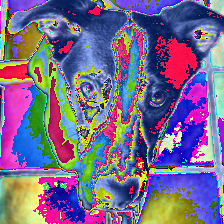

In [4]:
transforms.ToPILImage()(img_t)

### Loading  the model

Now we are going to load the pre-trained 18-layer ResNet model from the `torchvision` library.

In [5]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

Let's see how the model classifies Blas, the border collie. For this, we have to turn the image tensor into a minibatch of 1 example, which practically means adding an extra dimension to the tensor. This can be done using the `unsqueeze` function.

In [6]:
x = img_t.unsqueeze(0)
y = resnet18(x)
y.size()

torch.Size([1, 1000])

The model's output is a vector of 1000 logits, one for each class in the ImageNet dataset. To interpret this, we have to know what the ImageNet classes are. Also, the logits themselves are less human-readable, so we are going to turn them into probabilities using a `softmax` function. This helper function below will do this for us.

In [7]:
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)

def top_5_classes(y, class_names = None):
    if class_names==None:
        imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
        response = requests.get(imagenet_labels_url)
        class_names = json.loads(response.text)
        
    p = softmax(y[0,:], dim=0)
    values, indices = p.topk(5)
    return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

In [8]:
top_5_classes(y)

[('bucket', 0.007806162),
 ('plunger', 0.007172808),
 ('hook', 0.0070160483),
 ('waste container', 0.00548113),
 ('water bottle', 0.0054325894)]

Oops, the model doesn't seem to recognise Blas. It thinks Blas is a bucket, plunger or hook. This is because in order to use the pretrained models in pytorch, we have to set them to evaluation mode. When training deep neural networks, sometimes the networks work differently at training and test time. For example, when using a technique called dropout, random units in the network may be dropped at training time, but at test time, all units are used and their output is scaled. Similarly, when using batch normalisation, the network works differently in training time and at test time. To set models to evaluation mode we can use the `eval` function.

In [9]:
resnet18.eval()
y = resnet18(x)
top_5_classes(y)

[('Staffordshire Bull Terrier', 0.18194398),
 ('Cardigan Welsh Corgi', 0.1410219),
 ('American Staffordshire Terrier', 0.12816101),
 ('Basenji', 0.093432546),
 ('Whippet', 0.0912714)]

OK, getting there. At least the model now recognises Blas as a dog, but misses the specific breed. The correct class would be a Border Collie.

## Question A.1: Trying different pretrained networks

Now try different models from `torchvision` and see which ones can classify Blas correctly. In particular, check out deeper versions of ResNets. Use the [documentation](https://pytorch.org/vision/0.8/models.html) to find out what other networks are available. Use the code blocks below, and the text field to summarise what you found. (For full marks, try multiple ResNets, and at least two different non-ResNets).

*10 marks*

### Answer A.1

Please use this cell to summarise which networks you tried.

In [10]:
# please add code for question A.1 here. You may add further code cells below.
def test_model(model):
    model.eval()
    y = model(x)
    return top_5_classes(y)

In [11]:
#resnet34
resnet34 = models.resnet34(pretrained=True)
test_model(resnet34)

[('Border Collie', 0.37440842),
 ('Australian Kelpie', 0.1041623),
 ('Basenji', 0.09331903),
 ('Whippet', 0.06386915),
 ('collie', 0.06055793)]

In [12]:
#resnet50
resnet50 = models.resnet50(pretrained=True)
test_model(resnet50)

[('Border Collie', 0.26453555),
 ('collie', 0.18160017),
 ('Cardigan Welsh Corgi', 0.17722465),
 ('Whippet', 0.12113608),
 ('Australian Kelpie', 0.059639335)]

In [13]:
#resnet101
resnet101 = models.resnet101(pretrained=True)
test_model(resnet101)

[('Border Collie', 0.33726558),
 ('Basenji', 0.23494667),
 ('Cardigan Welsh Corgi', 0.1764275),
 ('collie', 0.06710177),
 ('Boston Terrier', 0.027117383)]

In [14]:
#resnet152
resnet152 = models.resnet152(pretrained=True)
test_model(resnet152)

[('Border Collie', 0.36757556),
 ('collie', 0.29964244),
 ('Whippet', 0.12551317),
 ('Cardigan Welsh Corgi', 0.07364106),
 ('Australian Kelpie', 0.033829577)]

In [15]:
#vgg19
vgg19 = models.vgg19(pretrained=True)
test_model(vgg19)

[('Cardigan Welsh Corgi', 0.67670065),
 ('Basenji', 0.12864794),
 ('Whippet', 0.117506735),
 ('Border Collie', 0.03454853),
 ('collie', 0.014183084)]

In [16]:
#alexnet
alexnet = models.alexnet(pretrained=True)
test_model(alexnet)

[('Whippet', 0.35440388),
 ('Basenji', 0.2335527),
 ('toy terrier', 0.12923813),
 ('Boston Terrier', 0.11565414),
 ('Italian Greyhound', 0.07830709)]

In [17]:
#googlenet
googlenet = models.googlenet(pretrained=True)
test_model(googlenet)

[('Whippet', 0.28620064),
 ('Great Dane', 0.11929929),
 ('American Staffordshire Terrier', 0.06753124),
 ('Staffordshire Bull Terrier', 0.05084431),
 ('Cardigan Welsh Corgi', 0.039121356)]

The ResNet models were the only models that predicted the correct class of 'Border Collie'. They unfortunately weren't able to predict Border Collie with extremely high likelihoods, with the higherst observed likelihood being about 0.4, however all of their to 5 predicted species were dogs.

The other models tried (VGG19, AlexNet and GoogleNet) weren't able to predict Border Collie but all of their top 5 species were dogs too

## Inspecting and modifying networks

For the next question, you will need to modify the pre-trained networks, and you will need to look inside them. Below, we share a few things that will help you learn how models work. First, let's look at what the `resnet18` architecture looks like and how that architecture is represented in pytorch. You can print the model to see a text description of it:

In [18]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, modules are listed from top to bottom in order of how they are executed.In a pytorch ResNet, residual blocks are organised into `layers`, each of which contain sequences of residual blocks. You will notice that:
* the number of channels keeps doubling at each layer, in this case from 128 -> 256 -> 512.
* at the same time, the figure size is halved with each layer. The image size is halved by `MaxPool2d` layers as well as strided convolutions where the stride is `2`.
* a `resnet18` is built out of `BasicBlock` building blocks, which are the simple residual block proposed by [He et al, (2015)](https://arxiv.org/abs/1512.03385) which I showed in the lecture. Deeper ResNets, such as `resnet50` use a more complicated `Bottleneck` component instead.
* in pytorch, the linear and nonlinear parts of a layer are separate, i.e. the convolution and subsequent ReLU activation are handled as separate layers.

To access the second convolution layer from the second residual block at the third layer, you can write the following:

In [19]:
resnet18.layer3[1].conv2

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

And you can access parameters of layers like so.

In [20]:
resnet18.conv1.weight.size()

torch.Size([64, 3, 7, 7])

We can visualise the convolution kernels on the first layer using the code below. In addition to showing how to access weights, you may find some of this code useful as an example of using the `matplotlib.pylab` package for plotting.

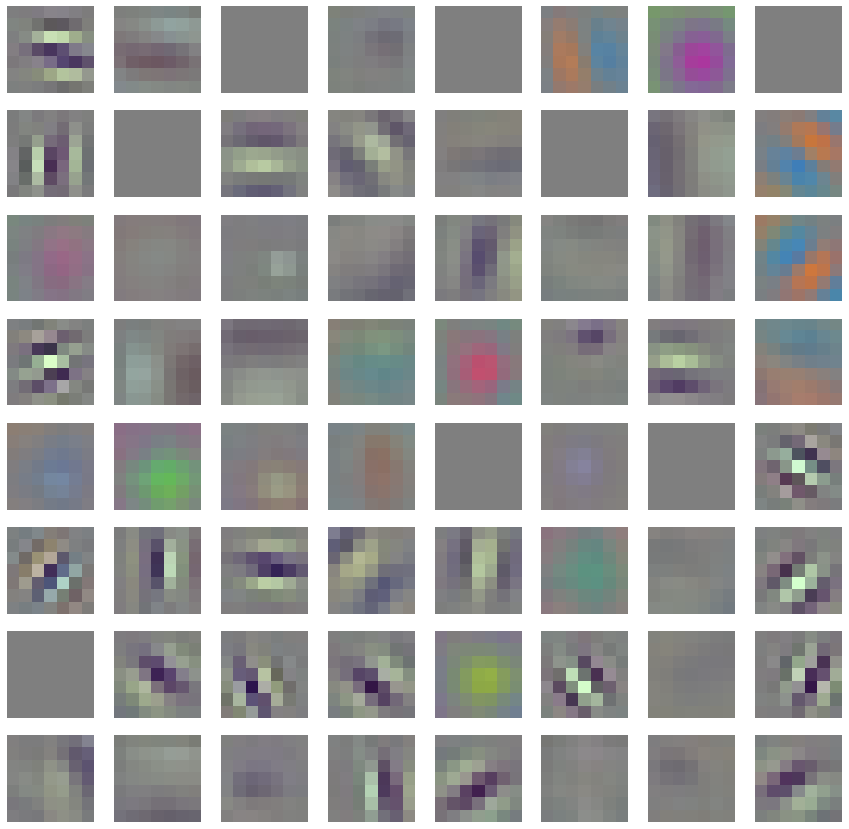

In [21]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (15,15))

weights = resnet18.conv1.weight.detach().numpy()

#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
    plt.subplot(8, 8, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(np.moveaxis(w, 0, -1));
    plt.axis('off')

In pytorch, you can inspect what each layer of the network does by using forward hooks. A forward hook is a python function that gets called whenever the layer is evaluated (i.e. data is passed through the layer). The forward hook function receives both the input and the output of the module. In pytorch, you can add a forward hook using the register_forward_hook function. 

For example, in the code below, I attach a hook to a layer, which simply prints something out. Instead of attaching the hook to the resnet18, I first create a `deepcopy` of the model, so the hook gets attached to the copy, but not to the `resnet18` model which I may use later.

In [22]:
import copy

def useless_hook(module, input, output):
    print('The hook was called.')

model = copy.deepcopy(resnet18)
model.layer3[1].conv2.register_forward_hook(useless_hook)
y = model(x)
y = model(x)

The hook was called.
The hook was called.


## Question A.2: Inspecting layers in neural networks

This question has a subtasks:
1. print the number of parameters in each of the operations/layers of the `ResNet18`, and count how many there are in total.
1. print the *shape of the output tensor* of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. *Tip:* you can use a forward hook.
1. Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. *Tip:* you can use a forward for this here, too.
1. Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the sape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

*15 marks*

### Answer A.2

please provide your answers in code cells below (you may use multiple code cells).

## Part 1 - print the number of parameters in each of the operations/layers of the ResNet18, and count how many there are in total

In [23]:
from IPython.core.display import display, HTML

#I am displaying as a html table to make it tidier
output = "<table>"
output += "<tr><th>Layer</th><th>Number of parameters</th></tr>"

import math

total = 0

for layer, param in resnet18.named_parameters():
    num_parameters = math.prod(param.size())
    output += f"<tr><td>{layer}</td><td>{num_parameters}</td></tr>"
    total += num_parameters
    
output += "</table>"

display(HTML(output))
print("Total number of parameters: " + str(total))

Total number of parameters: 11689512


## Part 2 print the shape of the output tensor of the second convolution operation (conv2) within every single residual block in a ResNet18

In [24]:
import torch

def hook(module, input, output):
    print(output.size())
    
model = copy.deepcopy(resnet18)

for layer in model.children():
    if isinstance(layer, torch.nn.Sequential):
        layer[0].conv2.register_forward_hook(hook)
        layer[1].conv2.register_forward_hook(hook)

_ = model(x)

torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 7, 7])


## Part 3 - Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using matplotlib.pylab.imshow

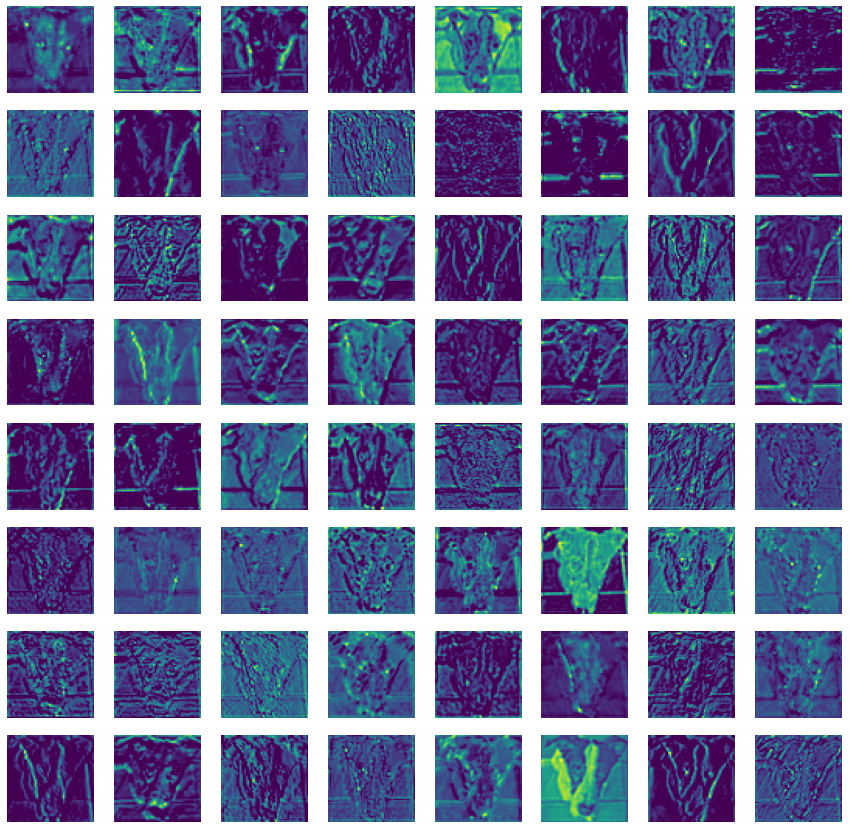

In [25]:
def hook(module, input, output):
    
    ##Convert to numpy
    activations = output.detach().numpy()
    
    #Get value from minibatch
    activations = activations[0]
       
    plt.gcf().set_size_inches((15, 15))
    
    for i, a in enumerate(activations):
        plt.subplot(8, 8, i+1)
        plt.imshow(a);
        plt.axis('off')

    
model = copy.deepcopy(resnet18)

#Extract the output of layer1
model.layer1.register_forward_hook(hook)

_ = model(x)

## Part 4 - Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.

In [26]:
def plot_weights(weights):
    
    weights = weights.detach().numpy()
    
    #normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
    weights = weights/(np.abs(weights).max())/2+0.5
    
    plt.gcf().set_size_inches((15, 15))

    #there are 64 convolution kernels, which we will arrange along an 8x8 grid
    for i, w in enumerate(weights):
        plt.subplot(8, 8, i+1)
        # we move the colour channel axis to the end, this is where imshow expects it
        plt.imshow(np.moveaxis(w, 0, -1));
        plt.axis('off')

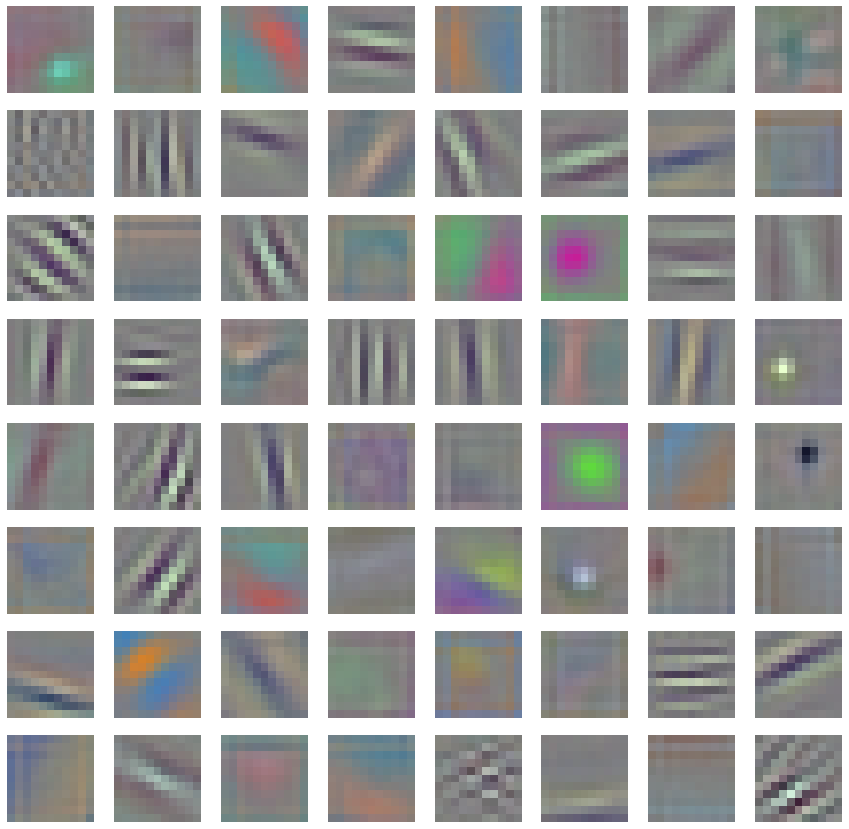

In [27]:
# AlexNet 
model = models.alexnet(pretrained=True)

# model.features[0] is the first convolutional layer
weights = model.features[0].weight
plot_weights(weights)

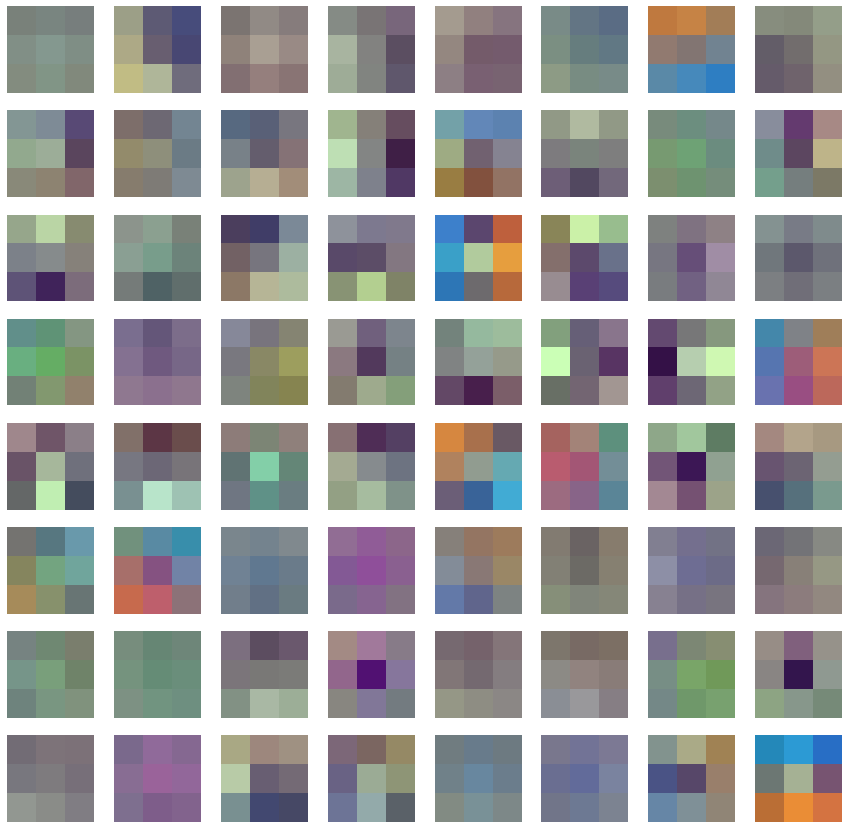

In [28]:
# vgg19
model = models.vgg19(pretrained=True)

# model.features[0] is the first convolutional layer
weights = model.features[0].weight
plot_weights(weights)

The main difference I see are the dimensions of each kernel - the kernels are only 3 x 3 for VGG19 but are 7 x 7 in ResNet and 11 x 11 in AlexNet (for the layers observed). 

The main similarity I see in the plots are the spectrums of colours observed. For example, each plot seems to have a few kernels consisting of mostly blue and orange (like the one in the bottom right here), but in general, most of the kernels are predominantly grey (suggesting small values). The AlexNet and ResNet kernels actually look a little bit more grey, but this could be an artefact of the kernel size.

## Editing models

Models can be edited rather flexibly in pytorch. Underlying a pytorch `Module` are python `OrderedDict` objects. These are ordered lists of key-value pairs. Each submodule and each parameter has a name, which is the key. Members of the dictionay can be accessed as attributes of the `Module`. Adding a new parameter or layer to a module will add a new key-value pair to this dictionary.

Let's try adding a new operation to our resnet18, which converts the logits to probabilities. We will do this by replacing the final operation by a `Sequential` module, which chains multiple operations together.

In [29]:
from torch.nn import Softmax, Sequential

model = copy.deepcopy(resnet18)

model.fc = Sequential(
    model.fc,
    Softmax(dim=1)
)

In [30]:
#let's see what the model looks like now
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's check the model still works and that it outputs a vector of probabilities which therefore sums to one.

In [31]:
y = model(x)
print(y.sum())

tensor(1., grad_fn=<SumBackward0>)


We can also replace existing layers with other layers. Here, for example, I replace the first convolution layer with a randomly initialized one of the same dimensions. We can check what effect this has on the classification of Blas:

In [32]:
from torch.nn import Conv2d

model = copy.deepcopy(resnet18)
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
y = model(x)
top_5_classes(y)

[('spider web', 0.7900706),
 ('barn spider', 0.13313687),
 ('shower curtain', 0.016085237),
 ('window shade', 0.009193916),
 ('European garden spider', 0.0071975277)]

Or, if we replace the convolutional layer by the convolutions from the VGG19 network, followed by a MaxPooling, to account for the difference in stride, the network becomes pretty certain that Blas is, in fact, spider web, or possibly a type of spider.

In [33]:
from torch.nn import MaxPool2d

vgg19 = models.vgg19(pretrained=True)

model = copy.deepcopy(resnet18)
model.conv1 = Sequential(
      vgg19.features[0],
      MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
y=model(x)
top_5_classes(y)

[('spider web', 0.90654683),
 ('barn spider', 0.03870481),
 ('European garden spider', 0.013483312),
 ('window screen', 0.011457858),
 ('wolf spider', 0.0041355444)]

## Question A.3: Dropping layers in ResNet15

This question is composed of several tasks:
1. Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. 
1. Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit morer involved than the previous one).
1. Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.
* You can solve this task using a few lines of code only.

*15 marks*

### Answers A.3

Please provide your answer in the code blocks below.

In [34]:
# dropping layer4 second block
model = copy.deepcopy(resnet18)
model.layer4[1] = torch.nn.Identity()
test_model(model)

[('Italian Greyhound', 0.0016954435),
 ('Boston Terrier', 0.0016745134),
 ('Basenji', 0.0016514725),
 ('space heater', 0.0016252266),
 ('Cardigan Welsh Corgi', 0.0015921455)]

In [35]:
# dropping layer 4 first block
model = copy.deepcopy(resnet18)

#Replace the BasicBlock with just the conv2d that's used for downsampling
model.layer4[0] = Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
model.layer4[0].weight = resnet18.layer4[0].downsample[0].weight
test_model(model)

[('Basenji', 0.49210998),
 ('cornet', 0.40565503),
 ('trombone', 0.059893604),
 ('oboe', 0.026350282),
 ('flute', 0.014729386)]

In [36]:
#2. dropping layer2 first block
model = copy.deepcopy(resnet18)

#Replace the BasicBlock with just the conv2d that's used for downsampling
model.layer2[0] = Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
model.layer2[0].weight = resnet18.layer2[0].downsample[0].weight
test_model(model)

[('frying pan', 0.16774914),
 ('pan flute', 0.16133139),
 ('face powder', 0.09367818),
 ('paper knife', 0.051738095),
 ('spatula', 0.036107216)]

Dropping the second block of the 4th layer still allowed the model to predict mostly dogs, although with less certainty than before. Dropping the first layer of the second clock made non-dog classes such as 'cornet' more likely, and dropping the first block of the second layer seemed to totally throw off the model and caused it to predict non-dog objects.

(Note - model.eval() get's called in the test_model function I wrote above)

## A convenience function: flattening ResNets

Residual blocks in pytorch ResNets are organised into 4 layers. I found this rather cumbersome for the next exercise we are going to do. In order to make ResNets easier to work with I created the convenience function below which can *flatten* the layer hierarchy of pytorch resnet models, merging the 4 layers into one, called `residual_blocks`. After flattening, instead of accessing `model.layer1[0]` you can do `model.residual_blocks[0]`.

In [37]:
from torch import nn
from collections import OrderedDict

def flatten_resnet(resnet_model):
    """
    Takes a pytorch resnet model and returns a copy of the same model in a 
    flattened format, where the residulal blocks are not divided into four layers
    but are instead all in a residual blocks component.
    """
    model = copy.deepcopy(resnet_model)
    residual_blocks = nn.Sequential(*model.layer1,
                *model.layer2,
                *model.layer3,
                *model.layer4)
    return nn.Sequential(OrderedDict([
     ('conv1', model.conv1),
     ('bn1', model.bn1),
     ('relu', model.relu),
     ('maxpool', model.maxpool),
     ('residual_blocks', residual_blocks),
     ('avgpool', model.avgpool),
     ('flatten', nn.Flatten()),
     ('fc', model.fc)
    ]))

## Question A.4: Dropping layers in ResNet50

Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).

Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.

Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?

*20 marks*

### Answers A.4

Please add text in this box, and use as many code cells below as you'd like.

In [38]:
resnet50 = flatten_resnet(models.resnet50(pretrained=True))
test_model(resnet50)

[('Border Collie', 0.26453555),
 ('collie', 0.18160017),
 ('Cardigan Welsh Corgi', 0.17722465),
 ('Whippet', 0.12113608),
 ('Australian Kelpie', 0.059639335)]

ResNet50 does indeed get the answer right

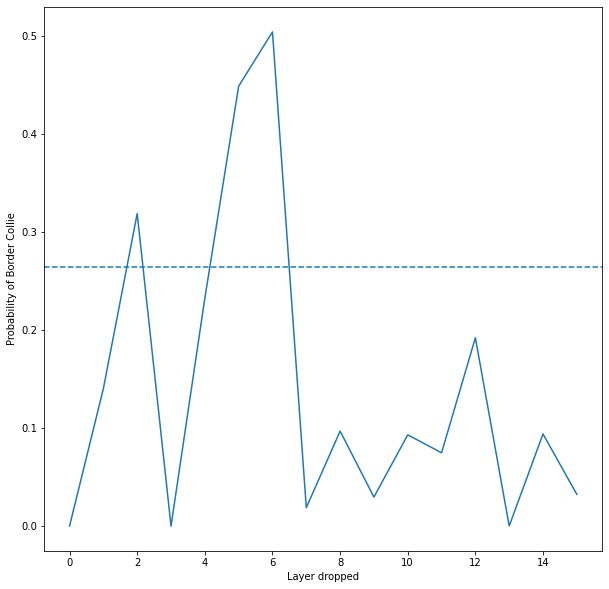

In [39]:
def replace_layer(i):
    """
    Returns a copy of resnet50 with layer i removed, either by 
    replacing it with the Identity layer or by using the downsampling method
    used in A.3
    """
    
    if not resnet50.residual_blocks[i].downsample or i == 15:
        model = copy.deepcopy(resnet50)
        model.residual_blocks[i] = torch.nn.Identity()
        return model
    
 
    outChannelsNeeded = resnet50.residual_blocks[i + 1].conv1.in_channels

    model = copy.deepcopy(resnet50)
    model.residual_blocks[i] =  resnet50.residual_blocks[i].downsample[0]
    model.residual_blocks[i].out_channels = outChannelsNeeded
    return model

xs, ys = [], []
for i in range(16):
    model = replace_layer(i)
    model.eval()
    predictions = model(x)
    p = softmax(predictions[0,:], dim=0)
    xs.append(i)
    ys.append(p[232])

# Plot unperturbed probability as horizontal line
resnet50.eval()
predictions = resnet50(x)
p = softmax(predictions[0,:], dim=0)
original_prob = p[232]

plt.plot(xs, ys)
plt.axhline(original_prob, linestyle="--")
plt.xlabel("Layer dropped")
plt.ylabel("Probability of Border Collie")
plt.gcf().set_size_inches((10, 10))

I see that for the most part, dropping layers reduced the model's predicted likelihood of Border Collie with layers 0, 3 and 13 (using zero-based indexing) being the most impactful. However, as seen by the dashed horizontal line, which shows the likelihood of Border Collie as predicted by the unperturbed model, dropping layers 2, 5 and 6 increased the model's predicted likelihood of Border Collie, with dropping layer 6 almost doubling it!

## Question A.5: Permuting and Repeating Layers

Now, let's see what happens if we permute or repeat layers in the ResNet.

1. Permute layers: Swap `resnet50.layer2[1]` and `resnet50.layer2[3]` in the network (so that instead of the second `Bottleneck` unit in `layer2` you use the fourth and vice versa). Make predictions with the modified network. How did perturbing the model this way modify the predictions?
1. Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?
1. Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?

*15 marks*

### Answers A.5

## Part 1

In [40]:
resnet50 = models.resnet50(pretrained=True)
model = copy.deepcopy(resnet50)
layer2List = list(model.layer2)
layer2List[1], layer2List[3] = layer2List[3], layer2List[1]
model.layer2 = torch.nn.Sequential(*layer2List)
test_model(model)

[('Border Collie', 0.5263512),
 ('collie', 0.19426748),
 ('Cardigan Welsh Corgi', 0.12698656),
 ('Australian Kelpie', 0.090844996),
 ('tennis ball', 0.009584238)]

Perturbing the model has nearly doubled the model's predicted likelihood of the Border Collie class

## Part 2

In [41]:
model = copy.deepcopy(resnet50)
layer2List = list(model.layer2)
b = layer2List[1]
layer2List.insert(2, b)
model.layer2 = torch.nn.Sequential(*layer2List)
test_model(model)

[('Border Collie', 0.31599727),
 ('Cardigan Welsh Corgi', 0.3141688),
 ('collie', 0.12030126),
 ('Australian Kelpie', 0.09171224),
 ('Basenji', 0.031745058)]

Perturbing the model in this way has increased the model's predicted likelihood of the Border Collie class a little, but not nearly as much as in part 1.

## Part 3

In [42]:
for reps in range(2, 6):
    model = copy.deepcopy(resnet50)
    layer2List = list(model.layer2)
    b = layer2List[1]
    
    # Have 'reps' repitions of the bottleneck block
    for _ in range(reps):
        layer2List.insert(2, b)
        
    model.layer2 = torch.nn.Sequential(*layer2List)
    print(f"{reps} Repitions: {test_model(model)}")
    print()

2 Repitions: [('Border Collie', 0.44836754), ('Australian Kelpie', 0.18681331), ('Cardigan Welsh Corgi', 0.09930866), ('collie', 0.083472185), ('Basenji', 0.06811619)]

3 Repitions: [('sea slug', 0.32154614), ('slot machine', 0.061015245), ('flatworm', 0.056214806), ('Windsor tie', 0.03382739), ('goldfish', 0.024146993)]

4 Repitions: [('slot machine', 0.6489886), ('ring-necked snake', 0.04689378), ('lighter', 0.04546302), ('flatworm', 0.030081391), ('goldfish', 0.027000321)]

5 Repitions: [('slot machine', 0.9128187), ('whistle', 0.038546868), ('lighter', 0.010157912), ('maraca', 0.005340066), ('goldfish', 0.0034453997)]



Having 2 repetitions has indeed improved the prediction, but 3, 4 and 5 has made it worse and has infact given us the wrong answers - 'Border Collie' is not even in the top 5 predicted classes.

# B: Recurrent Networks

In this part of the assignment, we will train simple recurrent networks to detect messages hidden in binary strings.

## Backgroud

### Creating the dataset

Below, I included a function which creates a pytorch `Dataset` we will use in the questions below. 


In [43]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def get_binary_dataset(num_datapoints, signature_length=20, random_length=20):
    '''
    Creates a labelled dataset of `num_datapoints` binary sequences. Each sequence
    is of total length `signature_length + random_length`. Positive examples have
    a signature string of length `signature_length` embedded starting at a random
    location within the string. The signature is a binary string of alternating 1s
    and 0s. Negative examples are random bitstrings. They may contain the
    signature by chance, although the probability of this diminishes as the
    `signature_legth` increases.

    The returned dataset contains positive examples first, followed by negatives.
    When using minibatch-SGD, the dataset has to be shuffled before broken into
    minibatches.

    Attributes
    ----------
    num_datapoints : int
    Number of datapoints to be generated. Half of the datapoints will be
    positive, the rest negative. If `num_datapoints==1` then the dataset will
    contain a single positive example.
    signature_length : int
    Length of the signature string
    random_length : int
    Number of random bits in the sequence in addition to the signature sequence.

    Returns
    -------
    torch.utils.data.TensorDataset
    Pytorch dataset containing the strings and their binary labels.
    '''
    num_positives = num_datapoints - num_datapoints // 2
    y = np.array([[1.0]]*num_positives + [[0.0]]*(num_datapoints - num_positives))
    X = np.random.randint(2, size=(num_datapoints, signature_length + random_length))
    signature = np.array((signature_length//2)*[1.0, 0.0])

    for i in range(num_positives):
        j = np.random.randint(random_length)
        X[i, j:(j+signature_length)] = signature
    
    X = torch.tensor(X, dtype=torch.float)[:, :, None]
    y = torch.tensor(y)
    return TensorDataset(X, y)

Below, I visualise a dataset of $100$ positive and $100$ negative sequences of lenth $40$ each. In the visualisation below, positive examples appear on top, negatives in the bottom half. Black pixels show $1$s, white pixels show $0$s. You can see the signature sequence `10101010101010101010` embedded in the positive examples at random locations.

*Notes:* You can see how I used `spy` to visualise a sparse matrix. This function can be used to show non-zero values in a matrix. The pytorch `TensorsDataset` object has a `tensors` attribute which contains the input and output tensors.

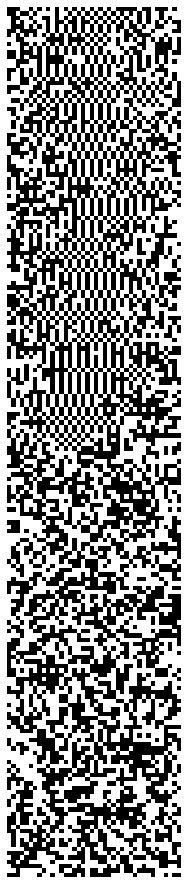

In [44]:
from matplotlib import pylab as plt

ds = get_binary_dataset(200,
                        signature_length=20,
                        random_length=20)

plt.figure(figsize=(4, 16))
plt.spy(ds.tensors[0][:, :, 0].numpy())
plt.axis('off');

## Building a classifier

Now we're going to build a simple RNN-based classifier for classifying binary sequences. We are going to feed the sequence into an RNN, then extract the hidden state activations at the end of the sequence, finally apply a linear transformation to calculate the classifier output.

An RNN module returns two outputs, as explained in [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). We have to select a layer which selects the second output - which is the activation of the hidden state at the end of the sequence - rearranges and flattens it so it's ready to be fed into a linear layer.

*Note:* By applying a further `sigmoid`, this classifier output can be turned into a probability, like it was the case with `softmax` the ResNet example. We are not going to make the sigmoid part of the network, as training will be more numerically stable this way

In [45]:
class extract_last_cell(nn.Module):
    '''Pytorch module which extracts and flattens the last hidden state of an RNN.
    '''
    def forward(self,x):
        _ , out = x
        return out.permute(1,0,2).flatten(start_dim=1)

def get_basic_RNN_classifier():
    return nn.Sequential(
        nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
        extract_last_cell(),
        nn.Linear(in_features = 20*2, out_features=1)
    )

## Question B.1: Evaluating the loss

Evaluate the log-loss of a randomly initialized classifier on minibatches of training examples from the dataset we defined before.

*Tips:*
* you can use [`pytorch/utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to sample minibatches of training data from the dataset
* or, you can also access the input and output tensors of a `TensorDataset` directly via the `tensors` attribute
* use [`torch.nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html)

*10 marks*

### Answer B.1

pleasse add answer in the code cell(s) below:

In [46]:
model = get_basic_RNN_classifier()
dataloader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)
for X, y in dataloader:
    y_hat = model(X)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(y, y_hat)
    print(loss)

tensor(1.0264, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0630, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9887, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0194, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1129, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0256, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1086, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0661, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8970, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0237, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0186, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9788, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9309, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


## Training the classifier

In the previous assignment we wrote a training loop to show how optimizers work in pytorch. For this assignment we are going to use ignite, a flexible module for reusable training loops in pytorch. We will install ignite, and then I provide a function you can use to train models on the sequence data.

In [47]:
# !pip install pytorch-ignite

In [48]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss

def fit_model_basic(model, training_dataset, test_dataset):
    '''Fits a pytorch model to the training dataset using stochastic gradient
    descent and tracks progress on a test set.

    Arguments
    ---------
    model : pytorch.nn.Module
        pytorch model that can be evaluated on input tensor in the dataset, and returns a tensor that matches the shape of the output tensor.
    
    training_dataset : pytorch.util.data.Dataset
        used to train the model
    
    test_dataset : pytorch.util.data.Dataset
        used to evaluate the performance of the model at the end of each epoch

    Retuns
    ------
    pytorch.nn.Module
        the model after training
    '''

    train_loader = DataLoader(
      training_dataset,
      batch_size=100,
      shuffle=True
    )
    val_loader = DataLoader(
      test_dataset,
      batch_size=1000,
      shuffle=False,
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.BCEWithLogitsLoss()

    trainer = create_supervised_trainer(model, optimizer, criterion)

    def thresholded_output_transform(output):
        y_pred, y = output
        
        # Convert to 0 if negative, 1 if positive
        y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
        
        return y_pred, y

    val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
    }
    
    evaluator = create_supervised_evaluator(model, metrics=val_metrics)

    @trainer.on(Events.ITERATION_COMPLETED(every=10))
    def log_training_loss(trainer):
        print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    trainer.run(train_loader, max_epochs=5)

    return model

The code above looks rather long and complicated, but that is because we ask ignite to log the progress of training in a very verbose way. Ignite uses python decorators (like the `@trainer.on(Events.EPOCH_COMPLETED)`) bits. You will find plenty of tutorials online if you google 'python decorators' if you want to learn more about them. In ignite, these decorators are used to register functions which are called when various events happen during training.

For example, `@trainer.on(Events.ITERATION_COMPLETED(every=10))` tells ignite to execute the function that's below it every 10th iteration is completed. You will find that this training loop is largely a copy of the example code provided in the [ignite master documentation](https://pytorch.org/ignite/quickstart.html#code).

One difference is that we use the `thresholded_output_transform` to tarnsform the network's output before [`Accuracy`](https://pytorch.org/ignite/metrics.html#ignite.metrics.Accuracy) metric can be evaluated. Accuracy compares binary predictions to binary labels. But our network outputs `logits` instead of binary predictors. To turn these into binary decisions, we have to determine whether the logits are above or below $0$, which is what the `heaviside` function does.

Ignite can do much more than what we ask it to do here. It's a flexible way of creating reproducible training loops for neural network training. It can handle distributed training over several machines, etc.

Let's now use our training loop to train a classifier on the binary dataset we created:

In [49]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)
rnn_classifier = get_basic_RNN_classifier()

fit_model_basic(rnn_classifier, ds_train, ds_test)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.70
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

Sequential(
  (0): RNN(1, 20, num_layers=2, batch_first=True)
  (1): extract_last_cell()
  (2): Linear(in_features=40, out_features=1, bias=True)
)

Oh no! The error doesn't seem like the loss is reduced. Let's try to fix this.



## Question B.2: Improving the SGD code

1. Create a new version of `fit_model_basic` function, call it `fit_model`. You will use this function in subsequent questions. Your function should take additional arguments allowing you to easily specify key hyperparameters of optimization: learning rate, batchsize, whatever else you find important.
1. Tune hyperparameters and change things until training works reliably. Consider [changing the optimizer](https://pytorch.org/docs/stable/optim.html) from vanilla SGD: you may try SGD with momentum, `Adam`, etc. You should be able to make this example work, i.e. reach $90\%+$ average accuarcy within a few seconds of training.

*Tips*:
 * You can try different learning rates, such as the [Karpathy constant](https://twitter.com/karpathy/status/801621764144971776). This is a joke, learning rates are usually problem-specific. Values between $0.1$ and $0.001$ are often tried.
 * If you want, you can run grid search: running training for different values of hyperparameters, and checkind which one produces the best results. If doing so, consider spacing parameter values logarithmically rather than linearly. I.e. it makes more sense to try learning rates $[0.001, 0.01, 0.1]$ than to try $[0.001, 0.002, 0.003, \ldots]$.

*15 marks*

### Answer B.2

Please modify the code in the cells below. You may use this text box to summarise the changes you made.

In [50]:
def fit_model(model, training_dataset, test_dataset, lr=0.001, batch_size=128, epochs=5, optimizer_func=torch.optim.Adam, criterion=nn.BCEWithLogitsLoss()):
    """
    The function now takes in the learning rate, batch size, number of epochs, the optimizer to use
    and the criterion (loss function) to use
    """


    train_loader = DataLoader(
      training_dataset,
      batch_size=batch_size,
      shuffle=True
    )
    
    val_loader = DataLoader(
      test_dataset,
      batch_size=1000,
      shuffle=False,
    )

    optimizer = optimizer_func(model.parameters(), lr=lr)
    optimizer.zero_grad()
    
    
    trainer = create_supervised_trainer(model, optimizer, criterion)

    def thresholded_output_transform(output):
        y_pred, y = output
        y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
        return y_pred, y

    val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
    }
    
    evaluator = create_supervised_evaluator(model, metrics=val_metrics)

    @trainer.on(Events.ITERATION_COMPLETED(every=10))
    def log_training_loss(trainer):
        print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    trainer.run(train_loader, max_epochs=epochs)

    return model

After doing some experimentation, I managed to get a working model using a learning rate of 0.001, batch size of 5, 7 epochs,
an Adam optimiser and BinaryCrossEntropyWithLogits as the loss function

In [51]:
classifier = fit_model(get_basic_RNN_classifier(), 
                    ds_train, 
                    ds_test,
                    lr=0.001,
                    batch_size=5,
                    epochs=7)

Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.64
Epoch[1] Loss: 0.84
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.63
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.62
Epoch[1] Loss: 0.50
Epoch[1] Loss: 0.59
Epoch[1] Loss: 0.48
Epoch[1] Loss: 0.45
Epoch[1] Loss: 0.48
Epoch[1] Loss: 0.36


Epoch[4] Loss: 0.71
Epoch[4] Loss: 0.72
Epoch[4] Loss: 0.53
Epoch[4] Loss: 0.68
Epoch[4] Loss: 0.58
Epoch[4] Loss: 0.78
Epoch[4] Loss: 0.75
Training Results - Epoch: 4  Avg accuracy: 0.47 Avg loss: 0.70
Validation Results - Epoch: 4  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[5] Loss: 0.76
Epoch[5] Loss: 0.70
Epoch[5] Loss: 0.71
Epoch[5] Loss: 0.80
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.71
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.87
Epoch[5] Loss: 0.54
Epoch[5] Loss: 0.72
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.47
Epoch[5] Loss: 0.58
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.56
Epoch[5] Loss: 0.66
Epoch[5] Loss: 0.79
Epoch[5] Loss: 0.56
Epoch[5] Loss: 0.58
Epoch[5] Loss: 0.75
Epoch[5] Loss: 0.74
Epoch[5] Loss: 0.38
Epoch[5] Loss: 0.66
Epoch[5] Loss: 0.48
Epoch[5] Loss: 0.66
Epoch[5] Loss: 0.35
Epoch[5] Loss: 0.59
Epoch[5] Loss: 0.66
Epoch[5] Loss: 0.54
Epoch[5] Loss: 0.26
Epoch[5] Loss: 0.40
Epoch[5] Loss: 0.59
Epoch[5] Loss: 0.32
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.22
Epoch[5] Loss: 0.45
Epoch[5] Los

## Question B.3: Test on longer sequences

Now that you successfully trained an RNN, let's test how well it works when we use it on longer sequences than what it was trained on. Does it have the ability to remember? Remember we trained on datasets with `signature_length=10, random_length=10`, that is a total length of `20` binary symbols.

* create 5 test datasets with `signature_length` of $10$ but with different `random_length` parameters (e.g. $10$, $20$, $30$, $50$ and $100$)
* evaluate accuracy of your trained model on each of these test regimes - (without retraining!)
* plot the performance you achieve for different test sequence lengths
* describe what you find

*Tips:*
* look inside the `fit_model` function for tips on evaluating models using ignite components.

*20 marks*

### Answers B.3

Please complete the task in code cells below.

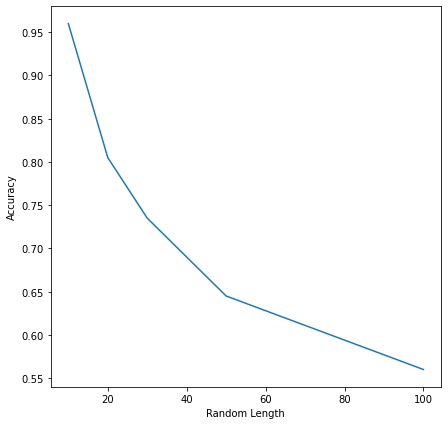

In [52]:

classifier.eval()
xs, ys = [], []
for random_length in [10, 20, 30, 50, 100]:
    
    xs.append(random_length)
    ds = get_binary_dataset(200,
                        signature_length=10,
                        random_length=random_length)
    
    X, y = ds.tensors
    y_hat = classifier(X)
    
    #Make it binary
    y_hat = torch.heaviside(y_hat, values=torch.zeros(1))
    
    acc = torch.sum(y == y_hat) / len(y)
    ys.append(acc)
    
    
    
plt.plot(xs, ys)
plt.xlabel("Random Length")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches((7, 7))

The accuracy goes down as the random length increases, almost in a linear fashion. The model does not remember very well

## Question B.4: Better models

Remember what we learned about vanilla RNN's ability to remember information over long time range. Pick a different RNN cell type that should have better ability to remember, and define a new network that uses this cell type. 
* Modify the function below to define an improved RNN classifier
* train an instance of this better RNN model on the same data we trained the previous classifier on
* repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

*15 marks*

### Answers B.4

Please edit the code below and add as many code cells as you would like to complete this task.

In [53]:
def get_better_RNN_classifier():
    '''
    A better RNN architecture for solving the signature detection problem. I use a GRU instead of an RNN
    '''
    return nn.Sequential(
        nn.GRU(input_size=1, hidden_size=50, num_layers=2, batch_first=True),
        extract_last_cell(),
        nn.Linear(in_features = 50*2, out_features=1)
    )

In [54]:
classifier_better = fit_model(get_better_RNN_classifier(), ds_train, ds_test,  
                    lr=0.001,
                    batch_size=5,
                    epochs=7)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.65
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.73
Epoch[1] Loss: 0.71
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.61
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.72
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.74
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.67
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.66
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.68
Epoch[1] Loss: 0.74


Epoch[4] Loss: 0.00
Epoch[4] Loss: 0.00
Epoch[4] Loss: 0.01
Epoch[4] Loss: 0.01
Epoch[4] Loss: 0.03
Epoch[4] Loss: 0.02
Epoch[4] Loss: 0.04
Epoch[4] Loss: 0.02
Epoch[4] Loss: 0.02
Training Results - Epoch: 4  Avg accuracy: 0.99 Avg loss: 0.04
Validation Results - Epoch: 4  Avg accuracy: 0.98 Avg loss: 0.06
Epoch[5] Loss: 0.02
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.01
Epoch[5] Loss: 1.02
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.03
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.00
Epoch[5] Loss: 0.03
Epoch[5] Loss: 0.02
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.01
Epoch[5] Loss: 0.93
Epoch[5] Loss: 0.02
Epoch[5] Los

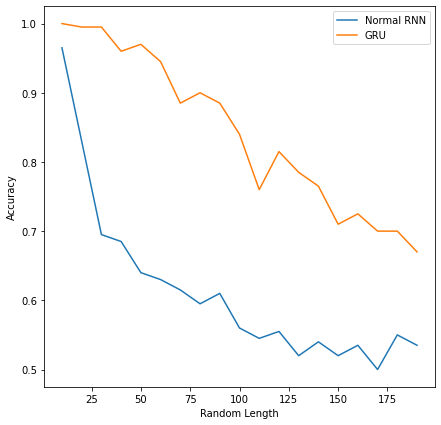

In [55]:
classifier_better.eval()
xs_better, ys_better = [], []
xs_simple, ys_simple = [], []

for random_length in range(10, 200, 10):
    
    # First compute accuracy for the model that uses a GRU
    xs_better.append(random_length)
    ds = get_binary_dataset(200,
                        signature_length=10,
                        random_length=random_length)
    
    X, y = ds.tensors
    y_hat = classifier_better(X)
    y_hat = torch.heaviside(y_hat, values=torch.zeros(1))
    acc = torch.sum(y == y_hat) / len(y)
    ys_better.append(acc)
    
    # Repeat for the vanilla RNN for comparison
    xs_simple.append(random_length)
    y_hat = classifier(X)
    y_hat = torch.heaviside(y_hat, values=torch.zeros(1))
    acc = torch.sum(y == y_hat) / len(y)
    ys_simple.append(acc)
    
plt.plot(xs_simple, ys_simple, label="Normal RNN")
plt.plot(xs_better, ys_better, label="GRU")
plt.xlabel("Random Length")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches((7, 7))
plt.legend()

The network that uses a GRU seemed to have performed slightly better for all random lengths tried. The graphs started off with accuracies close to 1 but as the rnadom length increased, the accuracy gap seemed to increase, suggesting the GRU network seemed to remember better

## Question B.5: Visualise memorization

Now we are going to visualize which parts of the input the trained architecture pays attention to when making its decision. This is going to be similar in spirit to [this distill post](https://distill.pub/2019/memorization-in-rnns/).
* take your pre-trained RNN classifier from the previous example
* generate a random positive input sequence (one that has a signature of length $10$ in it) and form an input tensor to the model.
* calculate the gradient of the model's output with respect to the input.

*Tips:*
* remember how we used `requires_grad` and `backward` and the `grad` attribute in the lecture to calculate the gradients of an RNN's hidden state with respect to the input sequence.
* remember the `TensorDataset` has a `tensors` argument which you can use to extract the input and output tensors from the dataset.

*15 marks*

### Answers B.5

Please add your solution to the code blocks below.

In [56]:
signature_length = 10
random_length = 10

#Generate the random sequence
X = np.random.randint(2, size=(1, signature_length + random_length))
signature = np.array((signature_length//2)*[1.0, 0.0])
j = np.random.randint(random_length)
X[0, j:(j+signature_length)] = signature
X = torch.tensor(X, dtype=torch.float)[:, :, None]

# Compute gradient
X.requires_grad = True
classifier(X).backward()
X.grad

tensor([[[-0.0261],
         [ 0.0489],
         [-0.0333],
         [-0.0023],
         [ 0.0561],
         [-0.0886],
         [ 0.0381],
         [ 0.0369],
         [-0.1056],
         [ 0.1243],
         [-0.0225],
         [-0.1176],
         [ 0.2018],
         [-0.1725],
         [ 0.0336],
         [ 0.0413],
         [-0.1059],
         [-0.1232],
         [-0.1831],
         [-0.3627]]])

## C Mini-Projects

Please **choose one** of the proposed mini-project questions below. Add as many text and code cells under the heading as you'd like. You may attempt more than one, but we will only mark one: please write below which mini-project you'd like to get marked on:

**I would like my solution for mini-project C1 to be marked.**

(I have deleted the other project descriptions just for less clutter in the notebook)

## C.1: Adversarial examples for ResNets

Adversarial examples for image classifiers are images which have been imperceptibly changed such that the classifier's output changes. For example, below we see an image of a panda, which the network correctly classifies as panda (left), but when we add a small amount of structured noise (middle), and feed the modified image (right) into the classifier, it now classifies it is a gibbon with high confidence.

![](https://openai.com/content/images/2017/02/adversarial_img_1.png)

In this mini-project, your task is to generate an adversarial examples for a pretrained convolutional neural network of your choice (VGG19, ResNet18 or ResNet50 are good choices). Use the image of Blas as a starting point. Change the image of Blas imperceptibly so that your network misclassifies him as a bus or sea slug, or any other arbitrary ImageNet class which is clearly not a dog. I recommend using the *fast gradient sign* method described on page 3 of [(Szegedy et al, 2013)](https://arxiv.org/pdf/1412.6572.pdf). *(40 marks)*

For full marks, explore the topic a bit more, example questions you can ask:
* Can you deliberately control what class you get after the adversarial attack? *(~20 marks)*
* Does the adversarial example generated for one network fool other networks, too? *(~20 marks for non-minimal investigation and good writeup)*
* Load another image. Does the adversarial noise generated for one image work to fool the network when added to a different image *(~20 marks for for non-minimal investigation and good writeup)*
* Can you generate adversarial examples without access to gradients, only using the forward pass of the network (this is called black-box adversarial attack)? *(~40 marks)*

*Tips:*
* The *fast gradient sign* method relies on gradients of the network's output with respect to pixel values in image space: you are looking for the smallest change to pixel values which maximally change the classifier's outputs. Remember how we did this using `requires_gradients` and `backward` in the RNN example.
* To illustrate the change is imperceptible, you want to apply the change to the untransformed image, i.e. before the normalisation is applied. The normalization is itself differentiable, so my advice is to make the normalization part of the network itself.

*80 marks*

## Implementation of the Fast Gradient Sign method

Here is my imlementation of the FGSM using Blas as an example. We can see that using an $\epsilon$ value of 0.1, we can fool resnet18 into thinking Blas is a "cardigan" or a "teddy bear". 

Note: I've copied various bits of code from above to use for the mini-project, so the mini-project code is not dependent on any of the code above. Also, as suggested in the tips, normalisation is made as part of the network - that is the purpose of the "Net" class which serves as a wrapper that first normalises the input

In [71]:
# Imports for this section
from PIL import Image
from torchvision import transforms, models
import requests
import json
import torch
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import numpy as np

In [72]:
def top_5_classes(y, class_names):
    p = softmax(y[0, :], dim=0)
    values, indices = p.topk(5)
    return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

def load_image(path):
    """
    Loads image as tensor and resizes it, but does not perform normalisation. Normalisation is instead done in the network
    """
    img = Image.open(path)

    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()])

    return transform(img)


def compute_gradient_sign(net, x, expected_class, loss_func=torch.nn.functional.cross_entropy):
    x.requires_grad = True
    output = net(x)
    loss = loss_func(output, torch.tensor([expected_class]))
    loss.backward()
    return x.grad.sign()


def show_img(img):
    if img.ndim == 4:
        img = img[0]

    img = transforms.ToPILImage()(img)
    plt.imshow(img)
    plt.show()


class Net(torch.nn.Module):

    def __init__(self, model):
        """Takes in a pretrained model as an argument, and normalises the input before feeding it into the model"""
        
        super().__init__()
        self.model = model

    def forward(self, x):

        #Normalise input as part of network
        transform = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        x = transform(x)

        #Then call model
        return self.model(x)

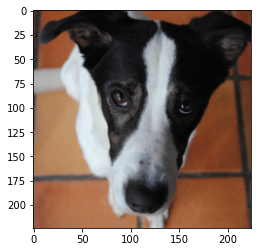

Original predicitons: [('Cardigan Welsh Corgi', 0.1719683), ('Staffordshire Bull Terrier', 0.16643912), ('American Staffordshire Terrier', 0.12468294), ('Great Dane', 0.10403919), ('Basenji', 0.09433317)]


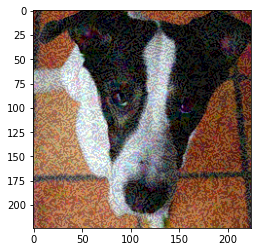

New predicitons: [('cardigan', 0.15287462), ('teddy bear', 0.13298321), ('wool', 0.04156397), ('mitten', 0.03807341), ('chain mail', 0.030592278)]


In [73]:
# Load the class names
imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
class_names = json.loads(response.text)
expected_class = class_names.index("Border Collie")

# Load Blas and make it 4-dimensional for the model
blas = load_image("blas_the_dog/test/blas.jpg")
x = blas.unsqueeze(0)


net = Net(models.resnet18(pretrained=True))
net.eval()

gradient_sign = compute_gradient_sign(net, x, expected_class=expected_class)

# Get perturbed image using FGSM formula
epsilon = 0.1
perturbed_image = (x + epsilon*gradient_sign).clamp(0, 1)

show_img(x)
print(f"Original predicitons: {top_5_classes(net(x), class_names=class_names)}")


show_img(perturbed_image)
print(f"New predicitons: {top_5_classes(net(perturbed_image), class_names=class_names)}")

## Can you deliberately control what class you get after the adversarial attack?

To do this, we can use the **Targeted FGSM attack**. While the goal of the FGSM attack is to **minimise** the likelihood of the true class, for the targeted variant, we are looking to **maximise** the output of the target class. This equates to using the formuls $x' = x - \nabla_x J(\theta, x, y_{target})$, where $J$ is the loss function, $x$ is the original image, $\theta$ is the parameters of the model and $y_{target}$ is the class we want the model to output


In order to make this work well, I extended the above formula and used the **iterative** method, which works similar to gradient descent with momentum.

In [74]:
# Make the model output sea slug

def demonstrate_targeted_fgsm(target_class):
    expected_class = class_names.index(target_class)

    x = blas.unsqueeze(0)
    epsilon = 0.05
    net = Net(models.resnet18(pretrained=True))
    net.eval()

    x_transformed = x

    # Perturb x using iterative targeted FGSM attack
    for t in range(1, 101):
        alpha = epsilon / t
        g = compute_gradient_sign(net, x_transformed, expected_class=expected_class)
        x_transformed = (x_transformed - alpha * g).detach().clamp(0, 1)


    show_img(x)
    print(f"Original predicitons: {top_5_classes(net(x), class_names=class_names)}")

    show_img(x_transformed)
    print(f"New predicitons: {top_5_classes(net(x_transformed), class_names=class_names)}")

Here is an example of making the model output "sea slug".

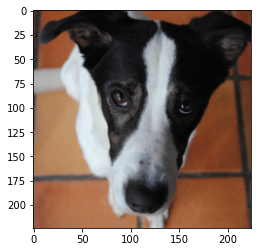

Original predicitons: [('Cardigan Welsh Corgi', 0.1719683), ('Staffordshire Bull Terrier', 0.16643912), ('American Staffordshire Terrier', 0.12468294), ('Great Dane', 0.10403919), ('Basenji', 0.09433317)]


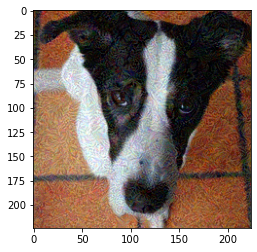

New predicitons: [('sea slug', 1.0), ('flatworm', 7.3508857e-09), ('starfish', 2.5194125e-09), ('torch', 2.3681146e-09), ('coral reef', 2.026089e-09)]


In [75]:
demonstrate_targeted_fgsm("sea slug")

Here is an example of making the model output "teddy bear"

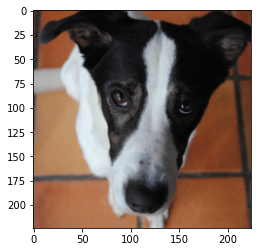

Original predicitons: [('Cardigan Welsh Corgi', 0.1719683), ('Staffordshire Bull Terrier', 0.16643912), ('American Staffordshire Terrier', 0.12468294), ('Great Dane', 0.10403919), ('Basenji', 0.09433317)]


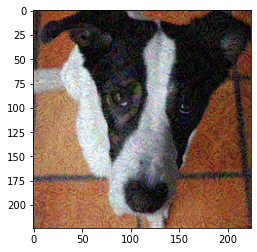

New predicitons: [('teddy bear', 1.0), ('toy store', 5.375295e-09), ('Toy Poodle', 2.6781435e-09), ('Standard Poodle', 2.6541664e-09), ('polar bear', 2.547555e-09)]


In [76]:
demonstrate_targeted_fgsm("teddy bear")

## Does the adversarial example generated for one network fool other networks, too?

Let's try perturbing our image of Blas using the FGSM attack for resnet18 as above, and seeing if that same image manages to fool resnet50 and resnet101

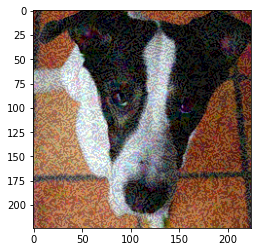

New predicitons: [('Boston Terrier', 0.6365279), ('Cardigan Welsh Corgi', 0.09305094), ('American Staffordshire Terrier', 0.056441266), ('collie', 0.03676705), ('Border Collie', 0.03178884)]


In [77]:
show_img(perturbed_image)
net = Net(models.resnet50(pretrained=True))
net.eval()
print(f"New predicitons: {top_5_classes(net(perturbed_image), class_names=class_names)}")

In [78]:
net = Net(models.resnet101(pretrained=True))
net.eval()
print(f"New predicitons: {top_5_classes(net(perturbed_image), class_names=class_names)}")

New predicitons: [('Boston Terrier', 0.9045008), ('toy terrier', 0.034902737), ('Cardigan Welsh Corgi', 0.012303707), ('Basenji', 0.008397644), ('Bluetick Coonhound', 0.004571807)]


We can see that although the models are failing to predict Border Collie, they are still predicting dogs - we haven't managed to completely fool them using an $\epsilon$ value of just 0.1 (as used in the original example with resnet18). This suggests that we might need more noise. In order to investigate this further, I have chosen 6 different pretrained models. For each of these models, I vary $\epsilon$ from 0.01 to 0.25 in steps of 0.01 and I have plotted the probability of the model predicting Blas as a dog.

In order to find the probability of a model predicting an image as a dog, I had to determine which Imagenet classes corresponded to dogs. I got the list of dog breeds from https://www.kaggle.com/c/dog-breed-identification/data. Unfortunately, the class names aren't quite the same as the ones retrieved from the json file above, e.g. capitalisation might be different and the names are slightly different sometimes, but as a heuristic to match them up I used the python library **difflib**, which is provided in the python library and can compute similarity between strings

Note that the gradient sign is still being computed only with our original model resnet18 - we are simply varying the level of noise and seeing how fooled each model gets 

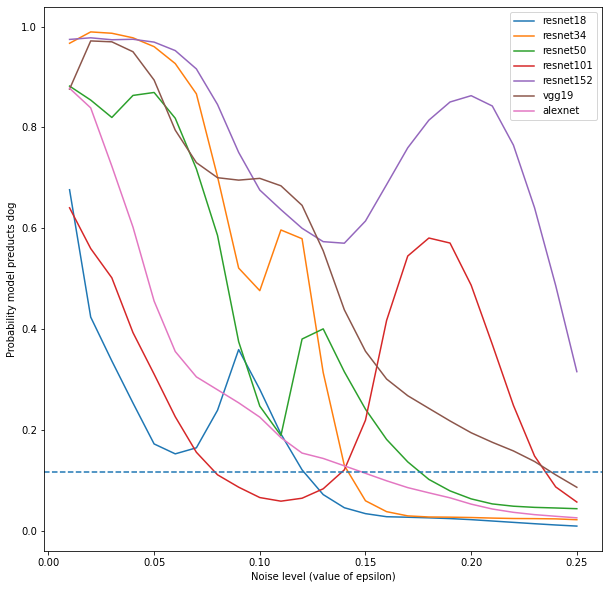

In [79]:
def probability_of_dog(net, x, dog_breeds_numeric):
    y = net(x)
    p = softmax(y[0, :], dim=0)
    return sum(p[index] for index in dog_breeds_numeric)



from difflib import SequenceMatcher

dog_breeds = set()
with open("dog_breeds.txt") as file:
    for line in file:
        breed = line.strip()
        max_score = -1
        most_likely_match = None
        for c in class_names:
            s = SequenceMatcher(None, breed, c)
            score = s.ratio()
            if score > max_score:
                max_score = score
                most_likely_match = c

        dog_breeds.add(most_likely_match)

dog_breeds_numeric = [class_names.index(breed) for breed in dog_breeds]
blas = load_image("blas_the_dog/test/blas.jpg")

x = blas.unsqueeze(0)
net = Net(models.resnet18(pretrained=True))
net.eval()
gradient_sign = compute_gradient_sign(net, x, expected_class=expected_class)


models_to_try = [
    models.resnet18(pretrained=True),
    models.resnet34(pretrained=True),
    models.resnet50(pretrained=True),
    models.resnet101(pretrained=True),
    models.resnet152(pretrained=True),
    models.vgg19(pretrained=True),
    models.alexnet(pretrained=True)
]

names = [
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "vgg19",
    "alexnet"
]

for i, model in enumerate(models_to_try):
    net = Net(model)
    net.eval()
    xs, ys = [], []
    for epsilon in np.arange(0.01, 0.26, 0.01):
        perturbed_image = (x + epsilon * gradient_sign).clamp(0, 1)
        xs.append(epsilon)
        ys.append(probability_of_dog(net, perturbed_image, dog_breeds_numeric))

    plt.plot(xs, ys, label=names[i])

expected_probability = len(dog_breeds) / len(class_names)
plt.axhline(expected_probability, linestyle="--")
plt.xlabel("Noise level (value of epsilon)")
plt.ylabel("Probability model preducts dog")
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()

The dashed horizontal line is the proportion of classes that were dog breeds - approximately 120/1000, i.e. the expected probability a model would predict a dog by random guessing. The ResNet18 model has also been plotted as a reference. We can see using noise levels of less than 0.18, we can trick ResNet34, ResNet50, AlexNet and ResNet101 to (probably) not predicting that this image is a dog. Bear in mind that there are 120 species of dogs, so the predicted probability of Border Collie is likely to be extremely low. VGG19 and ResNet152 seem to be more tolerant to the noise, with ResNet152 still fairly confident that the image is a dog with a noise level of 0.25. However, for the most part, I would say the noise generated by ResNet18 has managed to fool the other networks fairly well

## Load another image. Does the adversarial noise generated for one image work to fool the network when added to a different image?

I have downloaded a panda image from the internet. Here is an initial investigation - I have generated the noise by computing the gradient sign using Blas, and have added that to the panda image. Let's see if that manages to fool the model

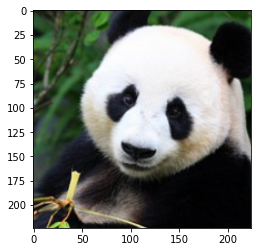

Original predicitons: [('giant panda', 0.99987173), ('indri', 6.221686e-05), ('gibbon', 2.2502743e-05), ('black-and-white colobus', 1.2053458e-05), ('white-headed capuchin', 9.420163e-06)]


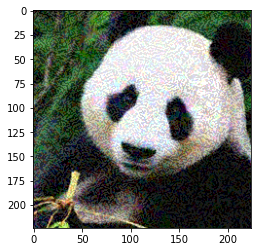

New predicitons: [('giant panda', 0.98963904), ('teddy bear', 0.0090705585), ('badger', 0.00017177472), ('Toy Poodle', 0.0001265608), ('indri', 0.000102327016)]


In [80]:
x = blas.unsqueeze(0)

net = Net(models.resnet18(pretrained=True))
net.eval()

gradient_sign = compute_gradient_sign(net, x, expected_class=expected_class)

# Load panda, then perturb it
panda = load_image("panda.png").unsqueeze(0)

show_img(panda)
print(f"Original predicitons: {top_5_classes(net(panda), class_names=class_names)}")

epsilon = 0.1
perturbed_image = (panda + epsilon * gradient_sign).clamp(0, 1)
show_img(perturbed_image)
print(f"New predicitons: {top_5_classes(net(perturbed_image), class_names=class_names)}")

That has not seemed to work well. Once again, that probably means we need more noise, so let's vary the noise level and see how that effects the model:



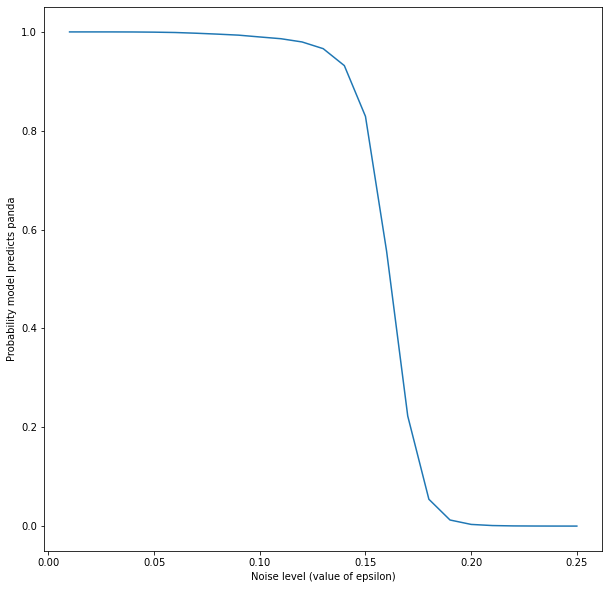

In [81]:
def prob_of_panda(net, x, class_names):
    y = net(x)
    probs = softmax(y[0], dim=0)
    return probs[class_names.index("giant panda")].item()

xs, ys = [], []
for epsilon in np.arange(0.01, 0.26, 0.01):
    perturbed_image = (panda + epsilon*gradient_sign).clamp(0, 1)
    xs.append(epsilon)
    ys.append(prob_of_panda(net, perturbed_image, class_names=class_names))

plt.xlabel("Noise level (value of epsilon)")
plt.ylabel("Probability model predicts panda")
plt.gcf().set_size_inches(10, 10)
plt.plot(xs, ys)
plt.show()

We see that the panda image seems to be less perceptible to the FGSM attack - it takes a noise level of about 0.2 to come close to fooling the model. Let's visualise the picture using this noise level and also see what output classes we're getting.

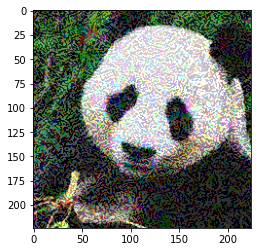

New predicitons: [('maze', 0.22220862), ('sea urchin', 0.16820875), ('manhole cover', 0.09253158), ('mask', 0.07116429), ('coral reef', 0.05101307)]


In [82]:
epsilon = 0.2
perturbed_image = (panda + epsilon*gradient_sign).clamp(0, 1)
show_img(perturbed_image)
print(f"New predicitons: {top_5_classes(net(perturbed_image), class_names=class_names)}")

One can observe that the change is not really imperceptible. In conclusion, the adversarial noise generated using Blas has not managed to fool the network's recognition of panda's very well

## Black-Box Adverserial Attacks

The code below assumes a GPU is available. Also, when I refer to the term "likelihood function", I mean the function that takes in an image and the correct class and model's class probability for this class (i.e. the function named 'P' in the code)

### Query-Limited attack

The first technique I investigated was the Query-Limited attack, sometimes known as the QL attack. This uses a technique called **NES Gradient Estimate** to estimate the gradient of the likelihood function with respect to the input. It then uses **projected** gradient descent to try to minimise the likelihood function, whilst also ensuring that the perturbed image pixels differ from the original pixels by no more than $\epsilon$. I used the folowing paper to learn about this algorithm:  https://arxiv.org/pdf/1804.08598.pdf.

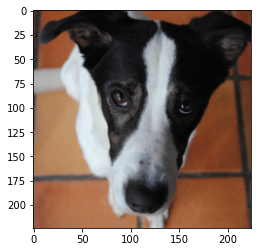

Old predicitons: [('Cardigan Welsh Corgi', 0.17196815), ('Staffordshire Bull Terrier', 0.1664393), ('American Staffordshire Terrier', 0.124683194), ('Great Dane', 0.1040394), ('Basenji', 0.09433318)]


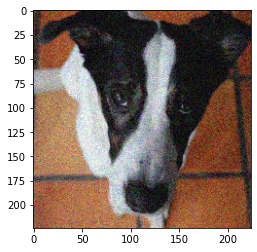

New predicitons: [('cowboy hat', 0.12183118), ('sweatshirt', 0.050752196), ('cardigan', 0.04223852), ('suit', 0.03736817), ('coffeemaker', 0.030341974)]


In [85]:
def P(net, x, y):
    x = x.cuda()
    return net(x)[0][y].item()

def estimate_gradient_sign(net, x, y, sigma=0.1, n=1):
    g = torch.zeros(x.shape)
    for _ in range(n):
        u = torch.normal(0, 1, size=x.shape)
        g += P(net, x + sigma * u, y) * u
        g -= P(net, x - sigma * u, y) * u

    return g.sign()


expected_class = class_names.index("Border Collie")
blas = load_image("blas_the_dog/test/blas.jpg")
x = blas.unsqueeze(0)
net = Net(models.resnet18(pretrained=True))
net.eval()
net.cuda()

epsilon = 0.15
x_transformed = x
lr = 0.001
for t in range(1, 10000):
    g = estimate_gradient_sign(net, x_transformed, expected_class)
    x_transformed = x_transformed - lr * g
    min = x - epsilon
    max = x + epsilon
    x_transformed = torch.max(torch.min(x_transformed, max), min).clamp(0, 1)
    
show_img(x)
print(f"Old predicitons: {top_5_classes(net(x.cuda()).cpu(), class_names=class_names)}")

show_img(x_transformed)
print(f"New predicitons: {top_5_classes(net(x_transformed.cuda()).cpu(), class_names=class_names)}")

### SIMBA

The other attack I tried was the SimBA attack, which stants for Simple Black-box attack and is outlined in the following paper: https://arxiv.org/pdf/1905.07121.pdf. In this variant, we essentially pick a random pixel in each iteration (without replacement), and we either increase or decrease it by $\epsilon$ - whichever reduces the likelihood function the most. The authors have provided a repository demonstrating the attack available at https://github.com/cg563/simple-blackbox-attack - some of the code written below takes code from the repository

In [86]:
def simba_single(model, x, y, num_iters=100000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = P(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = P(model, (x - diff.view(x.size())).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = P(model, (x + diff.view(x.size())).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
    return x


blas = load_image("blas_the_dog/test/blas.jpg")
x = blas.unsqueeze(0)
net = Net(models.resnet18(pretrained=True))
net.eval()
net.cuda()

x_transformed = simba_single(net, x, expected_class)
show_img(x)
print(f"Old predicitons: {top_5_classes(net(x.cuda()).cpu(), class_names=class_names)}")

show_img(x_transformed)
print(f"New predicitons: {top_5_classes(net(x_transformed.cuda()).cpu(), class_names=class_names)}")

KeyboardInterrupt: 